# Optional Bonus Questions: What is the potential of using natural language processing to analyze customer reviews and feedback?

## Implementing sentiment analysis on customer reviews

This optional deliverable demonstrates how Natural Language Processing (NLP) can be applied to analyze customer reviews of products. Customer reviews are invaluable sources of feedback that can guide product enhancements, improve customer service, and shape effective marketing strategies. By performing sentiment analysis and exploring common themes within this feedback, this analysis aims to understand customer satisfaction levels and uncover recurring issues or suggestions.

### Dataset
We are using a dataset of customer reviews specifically for the Amazon Alexa product, which allows for a more targeted and meaningful analysis. By focusing on a single product listing, this approach provides deeper insights into customer sentiment, satisfaction, and common concerns related to Amazon Alexa. Analyzing reviews for a particular product, as opposed to a broader range of unrelated items, ensures the results are more contextually relevant and actionable for product improvement, marketing strategies, and customer service enhancements.


In [16]:
import pandas as pd
import nltk
from nltk.data import find
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.downloader import Downloader

# Create a custom downloader to suppress download messages
class SilentDownloader(Downloader):
    def download(self, *args, **kwargs):
        kwargs['quiet'] = True  # Ensure quiet download
        super().download(*args, **kwargs)

# Load the dataset
file_path = 'amazon_alexa.tsv'
reviews_df = pd.read_csv(file_path, sep='\t')

# Drop irrelevant columns and set data types
reviews_df['rating'] = reviews_df['rating'].astype(int)
reviews_df = reviews_df.astype({'verified_reviews': 'string'})
reviews_df = reviews_df.drop(columns=['feedback'])

# Remove rows where 'verified_reviews' is NA or blank
reviews_df = reviews_df[reviews_df['verified_reviews'].notna()]


# Use the custom downloader to download resources
silent_downloader = SilentDownloader()

# Check and download 'vader_lexicon' if necessary
try:
    find('sentiment/vader_lexicon')
except LookupError:
    silent_downloader.download('vader_lexicon')

# Check and download 'stopwords' if necessary
try:
    find('corpora/stopwords')
except LookupError:
    silent_downloader.download('stopwords')

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(review):
    review = review.strip().lower()  # Lowercase and strip whitespace
    if review == "":  # Check if the review is empty after stripping
        return None
    
    # Remove punctuation and numbers
    review = ''.join([char for char in review if char not in string.punctuation and not char.isdigit()])

    # Remove stopwords
    review = ' '.join([word for word in review.split() if word not in stop_words])

    return review

# Apply preprocessing to 'verified_reviews' column
reviews_df['processed_reviews'] = reviews_df['verified_reviews'].apply(preprocess_text)

# Drop rows where 'processed_reviews' is None (originally blank or whitespace-only reviews)
reviews_df.dropna(subset=['processed_reviews'], inplace=True)
reviews_df.reset_index(drop=True, inplace=True)

### True Sentiment: Combining Rating and Review Sentiment

While the **rating** given by a customer is a strong indicator of sentiment, it doesn't always capture the full picture. A customer might leave a high rating but express mixed or negative feelings in their review, or vice versa. To gain a more accurate understanding of customer sentiment, we combine the **rating-based sentiment** with the **sentiment extracted from the review text** using **VADER** sentiment analysis. 

For example, consider a review where the customer gives a 5-star rating but writes, “The product is good, but the setup was frustrating and took much longer than expected.” The rating suggests satisfaction, but the review indicates some frustration. By analyzing both the rating and the review text, we can classify the True Sentiment as Mixed, rather than simply relying on the rating alone.

By incorporating both the rating and the review sentiment, we can determine a **True Sentiment** that reflects a more nuanced view of customer satisfaction. This approach helps account for any discrepancies between the rating and the review content, providing a clearer picture of how customers really feel.


In [17]:
# Initialize VADER for sentiment analysis
sia = SentimentIntensityAnalyzer()

# Define a function to get the VADER sentiment polarity score and classify it
def get_vader_sentiment_category(review):
    sentiment_score = sia.polarity_scores(review)['compound']
    if sentiment_score >= 0.25:
        return 'Positive'
    elif sentiment_score <= -0.25:
        return 'Negative'
    else:
        return 'Mixed'

# Apply VADER sentiment classification to each processed review
reviews_df['vader_sentiment'] = reviews_df['processed_reviews'].apply(get_vader_sentiment_category)

# Define a function to classify rating-based sentiment
def classify_rating_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Mixed'
    else:
        return 'Negative'

# Apply the rating classification function
reviews_df['rating_based_sentiment'] = reviews_df['rating'].apply(classify_rating_sentiment)

# Determine "true sentiment" by combining VADER and rating-based sentiment
def determine_true_sentiment(vader_sentiment, rating_sentiment):
    # Priority to negative if there's a disagreement
    if 'Negative' in (vader_sentiment, rating_sentiment):
        return 'Negative'
    # If both are positive, classify as positive
    elif vader_sentiment == 'Positive' and rating_sentiment == 'Positive':
        return 'Positive'
    # Default to mixed for any remaining cases
    else:
        return 'Mixed'

# Apply the function to create a true sentiment category
reviews_df['true_sentiment'] = reviews_df.apply(lambda row: determine_true_sentiment(row['vader_sentiment'], row['rating_based_sentiment']), axis=1)

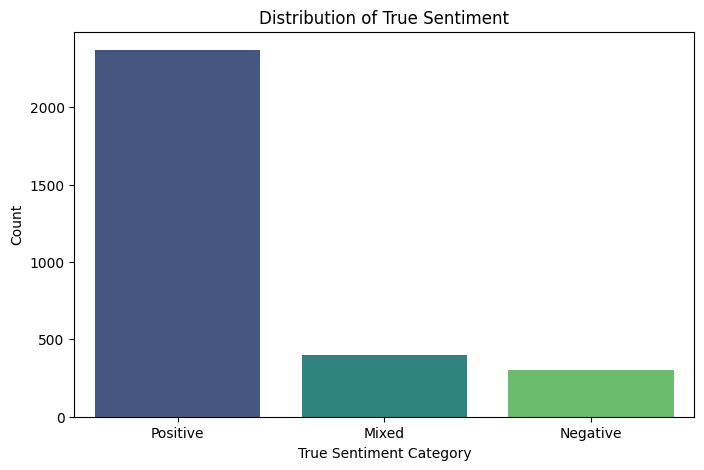

In [18]:
# Plot the distribution of the true sentiment categories
plt.figure(figsize=(8, 5))
sns.countplot(x='true_sentiment', data=reviews_df, hue='true_sentiment', order=['Positive', 'Mixed', 'Negative'], palette='viridis', legend=False)
plt.title('Distribution of True Sentiment')
plt.xlabel('True Sentiment Category')
plt.ylabel('Count')
plt.show()


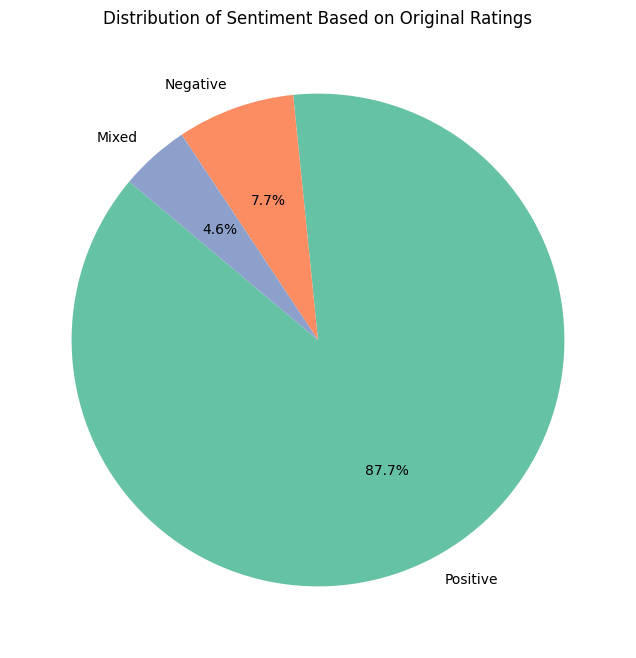

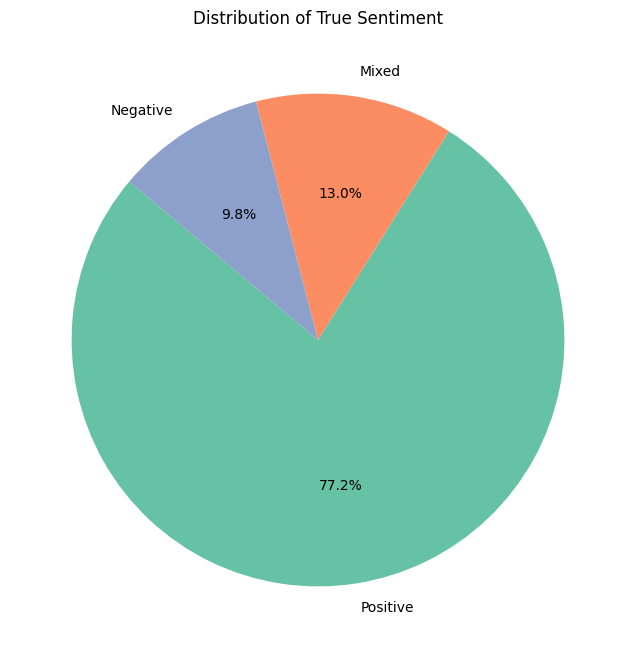

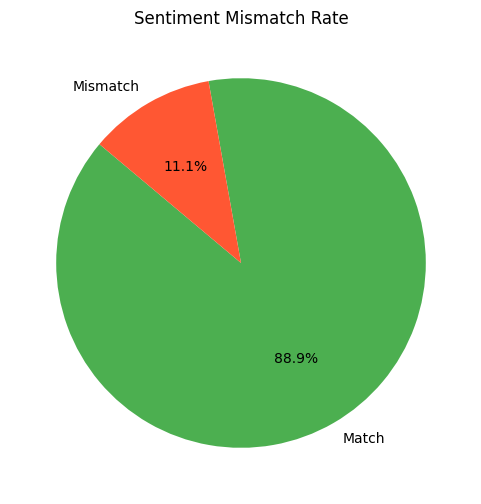

In [19]:
# Calculate the counts of each category in the original rating-based sentiment
rating_counts = reviews_df['rating_based_sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Sentiment Based on Original Ratings')
plt.show()

# Count the occurrences of each true sentiment category
true_sentiment_counts = reviews_df['true_sentiment'].value_counts()

# Plot a pie chart of the true sentiment categories
plt.figure(figsize=(8, 8))
plt.pie(true_sentiment_counts, labels=true_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of True Sentiment')
plt.show()

# Calculate the count of matching and mismatching sentiments
reviews_df['sentiment_mismatch'] = reviews_df['rating_based_sentiment'] != reviews_df['true_sentiment']
mismatch_counts = reviews_df['sentiment_mismatch'].value_counts()
labels = ['Match', 'Mismatch']
colors = ['#4CAF50', '#FF5733']  # Green for match, red for mismatch

# Plot as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(mismatch_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Sentiment Mismatch Rate')
plt.show()


From this we can see that there about 11% of reviews where the rating sentiment do not match the review sentiment. 

And after accounting for the review sentiment with the rating sentiment to get the true sentiment, the percentage of both negative and mixed sentiment almost doubled, while positive sentiment dropped.

In [20]:
# Filter for cases where original rating sentiment is Positive, but true sentiment is Negative
negative_true_from_positive_rating = reviews_df[
    (reviews_df['rating_based_sentiment'] == 'Positive') & (reviews_df['true_sentiment'] == 'Negative')
]

# Set pandas display option to show the full length of text fields
pd.set_option('display.max_colwidth', None)

# Now, display the filtered result with the full verified_reviews
result = negative_true_from_positive_rating[['verified_reviews', 'rating_based_sentiment', 'true_sentiment']]
print(result.head(3))



                                                                                                                                                                                                          verified_reviews  \
108                                                                                                                                                            The outlet does not work with it. Was disappointed in that.   
145  I have had Alexa since the beginning.  I accidentally spilled water on her and have replaced it with the 2nd generation.  I decided I couldn't be without an Echo.  Setup was easy and had it working within minutes.   
321                                                                                                               We really only use this as a speaker to stream music. We’ve had it 7 months and it’s just kinda useless.   

    rating_based_sentiment true_sentiment  
108               Positive       Negative  
145               Posit

In [21]:
reviews_df.head(3)

,rating,date,variation,verified_reviews,processed_reviews,vader_sentiment,rating_based_sentiment,true_sentiment,sentiment_mismatch
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,love echo,Positive,Positive,Positive,False
1,5,31-Jul-18,Charcoal Fabric,Loved it!,loved,Positive,Positive,Positive,False
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you. I like being able to turn lights on and off while away from home.",sometimes playing game answer question correctly alexa says got wrong answers like able turn lights away home,Mixed,Positive,Mixed,True




## Identifying Common Issues and Suggestions from Customer Feedback

In this section, we use **Natural Language Processing (NLP)** techniques, specifically **n-grams** and **CountVectorizer**, to identify the most common issues and suggestions from customer feedback.

1. **N-grams**:  
   N-grams are sequences of **n** words that appear together in the text. For example, a **unigram** is a single word (e.g., "battery"), and a **bigram** is a pair of words (e.g., "battery life"). By looking at n-grams, we can capture common phrases or issues that customers mention, like "poor quality" or "customer service."

2. **CountVectorizer**:  
   **CountVectorizer** is used to count how often each word or n-gram appears in the reviews. We apply this technique to the negative and mixed reviews to identify the most frequent words or phrases. By excluding common, non-informative words (like "the", "is", or product names), we can focus on the meaningful terms that highlight customer concerns or suggestions.

These methods help us identify recurring issues in customer feedback, such as common complaints about product features, customer service, or usability.

Top Common Issues and Suggestions from Negative Feedback:
   Word/Phrase  Count
13       music     99
5       device     85
26         use     80
28        work     74
22       sound     71
25        time     66
23     speaker     63
29       works     59
16     product     58
24       still     54
18      really     48
17     quality     48
19      screen     47
1         also     46
20         set     46
15        play     45
12        much     45
10          im     45
2       better     44
14        need     43
9         home     43
21        show     42
0        alarm     42
8         good     41
7         dont     40
4        could     40
3         cant     40
27        well     40
11        know     39
6       doesnt     38


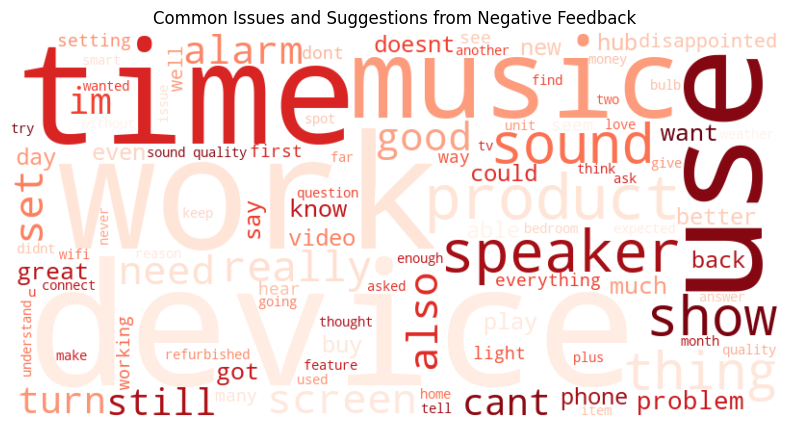

In [22]:
# Define custom blacklist of words to exclude
blacklist_words = ['amazon', 'alexa', 'echo', 'bought', 'purchase', 'app', 'like', 'dot', 'would', 'get','one']

# Combine stop words with the blacklist words
stop_words = list(set(stopwords.words('english')).union(blacklist_words))

# Filter for negative reviews based on true sentiment
negative_feedback_df = reviews_df[reviews_df['true_sentiment'].isin(['Negative', 'Mixed'])]

# Initialize CountVectorizer with custom stop words and n-grams
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1, 1), max_features=30)

# Fit and transform the processed reviews of negative feedback
X = vectorizer.fit_transform(negative_feedback_df['processed_reviews'])

# Sum up the counts of each word/phrase
word_counts = X.toarray().sum(axis=0)

# Map words/phrases to their counts and convert to a DataFrame for easy display
common_issues_df = pd.DataFrame({'Word/Phrase': vectorizer.get_feature_names_out(), 'Count': word_counts})
common_issues_df = common_issues_df.sort_values(by='Count', ascending=False)

# Display the most common issues and suggestions
print("Top Common Issues and Suggestions from Negative Feedback:")
print(common_issues_df)

# Generate text from common issues by combining all processed negative reviews
text_for_wordcloud = ' '.join(negative_feedback_df['processed_reviews'])

# Create and configure the word cloud
wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', 
    stopwords=stop_words, 
    max_words=100, 
    colormap='Reds'
).generate(text_for_wordcloud)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Issues and Suggestions from Negative Feedback')
plt.show()


Top Common Issues and Suggestions from Negative and Mixed Feedback:
            Word/Phrase  Count
14        sound quality     25
17           things try     14
6           google home     14
12           play music     13
13            prime day     13
19           works well     11
18           works fine     10
15       still learning      9
10           music play      9
5            fire stick      9
9           much better      8
2           doesnt work      8
0           alarm clock      8
1          could better      7
8           light bulbs      7
7   internet connection      7
4             dont need      7
3             dont know      7
11        nd generation      6
16      stopped working      6


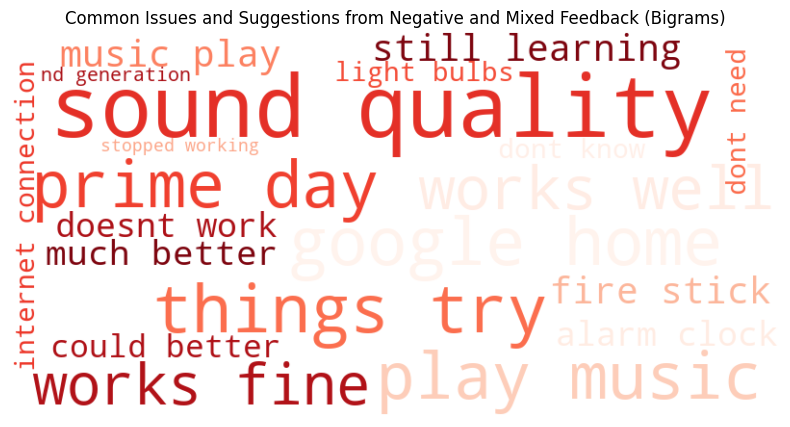

In [23]:
# Define custom blacklist of words to exclude
blacklist_words = ['amazon', 'alexa', 'echo', 'bought', 'purchase', 'app', 'like', 'dot', 'would', 'get', 'one']

# Combine stop words with the blacklist words
stop_words = list(set(stopwords.words('english')).union(blacklist_words))

# Filter for negative and mixed reviews based on true sentiment
negative_feedback_df = reviews_df[reviews_df['true_sentiment'].isin(['Negative', 'Mixed'])]

# Initialize CountVectorizer with custom stop words and bigrams only (ngram_range=(2, 2))
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(2, 2), max_features=20)

# Fit and transform the processed reviews of negative feedback
X = vectorizer.fit_transform(negative_feedback_df['processed_reviews'])

# Sum up the counts of each bigram
word_counts = X.toarray().sum(axis=0)

# Map bigrams to their counts and convert to a DataFrame for easy display
common_issues_df = pd.DataFrame({'Word/Phrase': vectorizer.get_feature_names_out(), 'Count': word_counts})
common_issues_df = common_issues_df.sort_values(by='Count', ascending=False)

# Display the most common bigrams as issues and suggestions
print("Top Common Issues and Suggestions from Negative and Mixed Feedback:")
print(common_issues_df)

# Create a dictionary for bigrams and their frequencies
bigrams_dict = dict(zip(common_issues_df['Word/Phrase'], common_issues_df['Count']))

# Create and configure the word cloud based on bigrams
wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', 
    max_words=100, 
    colormap='Reds'
).generate_from_frequencies(bigrams_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Issues and Suggestions from Negative and Mixed Feedback (Bigrams)')
plt.show()


Top Common Positive Feedback Phrases:
   Word/Phrase  Count
11       music    426
27         use    385
4         easy    326
29       works    319
22       sound    263
19         set    250
7         good    232
15     product    191
23     speaker    173
8         home    172
13        play    170
21       smart    163
24       still    149
12         new    148
17      really    145
6          fun    143
14       prime    131
1       better    131
26        time    129
3       device    128
10        much    127
5          far    124
0         also    122
28        well    121
16     quality    118
2          day    118
9           im    110
25      things    109
18        room    108
20        show    106


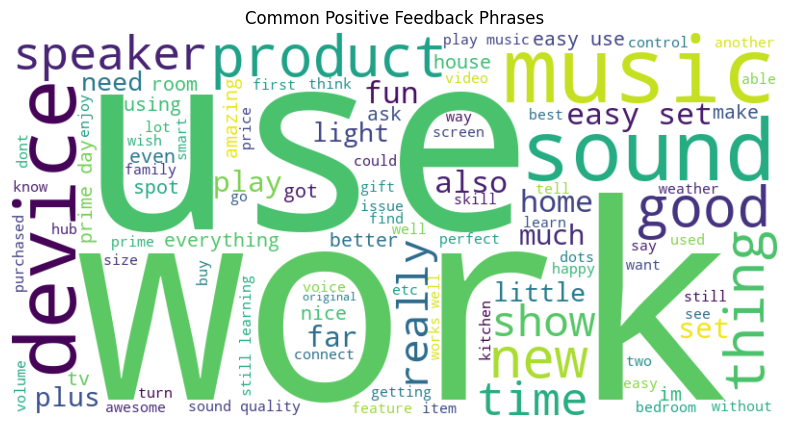

In [24]:
# Define custom blacklist of words to exclude
blacklist_words = ['amazon', 'alexa', 'echo', 'bought', 'purchase', 'app', 'like', 'dot', 'would', 'get', 'one','love','great']

# Combine stop words with the blacklist words
stop_words = list(set(stopwords.words('english')).union(blacklist_words))

# Filter for positive reviews based on true sentiment
positive_feedback_df = reviews_df[reviews_df['true_sentiment'] == 'Positive']

# Initialize CountVectorizer with custom stop words and unigrams (single words)
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1, 1), max_features=30)

# Fit and transform the processed reviews of positive feedback
X = vectorizer.fit_transform(positive_feedback_df['processed_reviews'])

# Sum up the counts of each word/phrase
word_counts = X.toarray().sum(axis=0)

# Map words/phrases to their counts and convert to a DataFrame for easy display
common_positive_df = pd.DataFrame({'Word/Phrase': vectorizer.get_feature_names_out(), 'Count': word_counts})
common_positive_df = common_positive_df.sort_values(by='Count', ascending=False)

# Display the most common positive phrases
print("Top Common Positive Feedback Phrases:")
print(common_positive_df)

# Generate text for the word cloud by combining all processed positive reviews
text_for_wordcloud = ' '.join(positive_feedback_df['processed_reviews'])

# Create and configure the word cloud
wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', 
    stopwords=stop_words, 
    max_words=100, 
    colormap='viridis'
).generate(text_for_wordcloud)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Positive Feedback Phrases')
plt.show()


Top Common Praises and Positive Feedback:
        Word/Phrase  Count
18      works great    136
2          easy set    126
4          easy use     77
6     great product     76
12       play music     74
14        prime day     74
16    sound quality     71
17   still learning     64
7       great sound     54
10        love love     47
19       works well     44
15       smart home     41
8      listen music     37
3        easy setup     36
13    playing music     33
1       alarm clock     32
5        fire stick     31
0   absolutely love     30
11        love show     23
9       living room     22


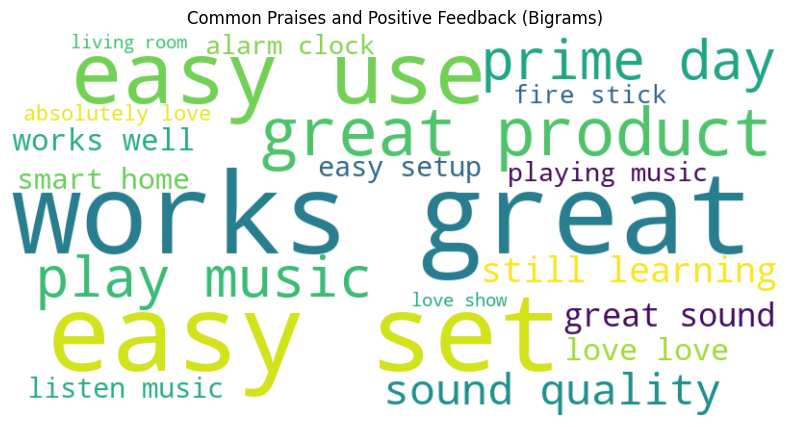

In [25]:
# Define custom blacklist of words to exclude
blacklist_words = ['amazon', 'alexa', 'echo', 'bought', 'purchase', 'app', 'like', 'dot', 'would', 'get', 'one']

# Combine stop words with the blacklist words
stop_words = list(set(stopwords.words('english')).union(blacklist_words))

# Filter for positive reviews based on true sentiment
positive_feedback_df = reviews_df[reviews_df['true_sentiment'] == 'Positive']

# Initialize CountVectorizer with custom stop words and bigrams only (ngram_range=(2, 2))
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(2, 2), max_features=20)

# Fit and transform the processed reviews of positive feedback
X = vectorizer.fit_transform(positive_feedback_df['processed_reviews'])

# Sum up the counts of each bigram
word_counts = X.toarray().sum(axis=0)

# Map bigrams to their counts and convert to a DataFrame for easy display
common_praises_df = pd.DataFrame({'Word/Phrase': vectorizer.get_feature_names_out(), 'Count': word_counts})
common_praises_df = common_praises_df.sort_values(by='Count', ascending=False)

# Display the most common bigrams as praises and positive feedback
print("Top Common Praises and Positive Feedback:")
print(common_praises_df)

# Create a dictionary for bigrams and their frequencies
bigrams_dict = dict(zip(common_praises_df['Word/Phrase'], common_praises_df['Count']))

# Create and configure the word cloud based on bigrams
wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', 
    max_words=100, 
    colormap='viridis'
).generate_from_frequencies(bigrams_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Praises and Positive Feedback (Bigrams)')
plt.show()


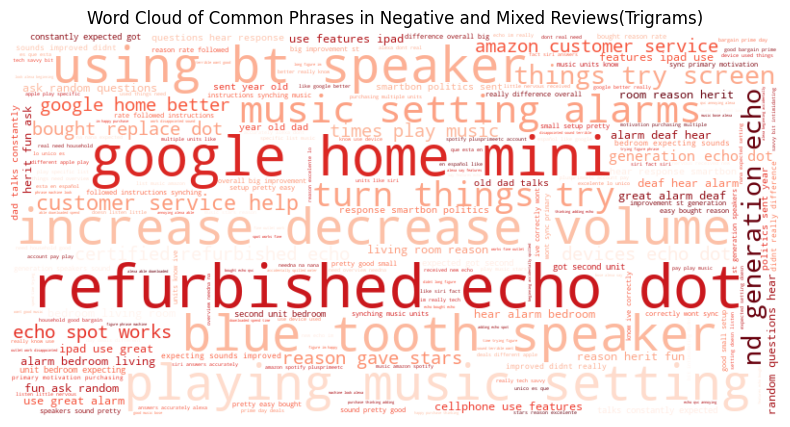

In [26]:
# Step 1: Filter for Negative and Mixed reviews
negative_mixed_reviews = reviews_df[reviews_df['true_sentiment'].isin(['Negative', 'Mixed'])]

# Combine all reviews text into a single string
text = ' '.join(negative_mixed_reviews['processed_reviews'])

# Step 2: Generate n-grams (bigrams or trigrams)
# You can set ngram_range=(2, 2) for bigrams or ngram_range=(3, 3) for trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
ngrams = vectorizer.fit_transform([text])

# Sum up the counts of each bigram
ngram_counts = ngrams.toarray().sum(axis=0)
ngram_freq = {word: ngram_counts[idx] for word, idx in vectorizer.vocabulary_.items()}

# Step 3: Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(ngram_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Common Phrases in Negative and Mixed Reviews(Trigrams)")
plt.show()


We decided to use Bigrams (two-word phrases) and Trigrams (three-word phrases) to identify common issues and suggestions from customer reviews. Unlike single words, bigrams and trigrams capture more meaningful phrases that provide deeper insights into customer sentiment.

For instance, one of the most frequent phrases identified in the reviews is "sound quality", suggesting that this could be a significant area of concern for customers. This type of insight is valuable for product development because it highlights specific aspects of the product (like sound quality) that may require attention or improvement.